In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from matplotlib.pyplot import figure
sns.set()

<h1 style="color:blue">Load Datasets</h1>

## DF Coop

In [2]:
df_coop = pd.read_csv("coop_top_100_ 201908.csv", encoding="latin1", sep=";")

In [3]:
#transformar data em index de data
df_coop['data'] = pd.to_datetime(df_coop['data'], format="%Y%m")
#df.set_index("data",inplace=True, drop=True)

In [4]:
#Arrumar valores separados por virgula
df_coop['valor']= df_coop['valor'].str.replace(",", ".")
df_coop['valor'] = pd.to_numeric(df_coop['valor'])

In [5]:
df_coop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130368 entries, 0 to 130367
Data columns (total 5 columns):
data        130368 non-null datetime64[ns]
id_coop     130368 non-null int64
nome        130368 non-null object
variavel    130368 non-null object
valor       130368 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.0+ MB


## DF B1

In [6]:
df_b1= pd.read_csv("BANCOS_B1.csv", encoding="latin1", sep=";")

In [7]:
#transformar data em index de data
df_b1['data'] = pd.to_datetime(df_b1['data'], format="%Y%m")

In [8]:
#Arrumar valores separados por virgula
df_b1['valor']= df_b1['valor'].str.replace(",", ".")
df_b1['valor'] = pd.to_numeric(df_b1['valor'])

In [9]:
df_b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132216 entries, 0 to 132215
Data columns (total 5 columns):
data        132216 non-null datetime64[ns]
id_banco    132216 non-null int64
nome        132216 non-null object
variavel    132216 non-null object
valor       132216 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.0+ MB


## DF B2

In [10]:
df_b2 = pd.read_csv("BANCOS_B2.csv", encoding="latin1", sep=";")

In [11]:
#transformar data em index de dataf
df_b2['data'] = pd.to_datetime(df_b2['data'], format="%Y%m")

In [12]:
#Arrumar valores separados por virgula
df_b2['valor']= df_b2['valor'].str.replace(",", ".")
df_b2['valor'] = pd.to_numeric(df_b2['valor'])

In [13]:
df_b2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70770 entries, 0 to 70769
Data columns (total 5 columns):
data        70770 non-null datetime64[ns]
id_banco    70770 non-null int64
nome        70770 non-null object
variavel    70770 non-null object
valor       70770 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.7+ MB


<h1 style="color:blue">IDs</h1>

In [14]:
ids_coop = df_coop['id_coop'].drop_duplicates().reset_index(drop=True)
ids_coop.count()

100

In [15]:
ids_b1= df_b1['id_banco'].drop_duplicates().reset_index(drop=True)
ids_b1.count()

100

In [16]:
ids_b2= df_b2['id_banco'].drop_duplicates().reset_index(drop=True)
ids_b2.count()

65

<h1 style="color:blue">Fórmula</h1>

<h2 style="color:green">
<p>t é o ano</p>
$spread_{coop}=\left(\frac{RdOC_{t}}{\frac{OpC_{t}+OpC_{t-1}}{2}}\right)-
\left(\frac{DCap_{t}}{\frac{Capt_{t}+Capt_{t-1}}{2}}\right) - 
\left(\frac{PartLuc_{t} + JCP_{t}} 
{\frac 
    {\mid\left(
        \frac{OpC_{t} + OpC_{t - 1}}
        {2}
    \right)-
    \left(
        \frac{Capt_{t} + Capt_{t-1}}
        {2}
    \right)\mid}
{2}}\right)$
</h2>

<h1 style="color:blue">Pivoting</h1>

## Pivot Coop

In [17]:
def pivot_coop(id):
    #print('este e o id: ')
    #print(id)
    pivot = df_coop[df_coop['id_coop']== id].pivot(index='data', columns='variavel',values='valor')
    pivot = pivot.groupby(pivot.index.year).sum()
    pivot['id'] = id
    pivot['OpC_off_1'] = pivot['IF.DATA_OpC'].shift(1)
    #pivot['OpC_off_12'] = pivot['IF.DATA_OpC'].shift(12)
    pivot['Capt_off_1'] = pivot['IF.DATA_Capt'].shift(1)
    #pivot['Capt_off_12'] = pivot['IF.DATA_Capt'].shift(12)
    pivot['taxApl'] = pivot['IF.DATA_RdOC'] / ((pivot['IF.DATA_OpC'] + pivot['OpC_off_1'])/2)
    pivot['taxCapt'] = pivot['IF.DATA_DCap'] / ((pivot['IF.DATA_Capt'] + pivot['Capt_off_1'])/2)
    pivot['spread_banc'] = pivot['taxApl'] +  pivot['taxCapt'] # a captação tem sinal negativo
    pivot['termo_coop'] = \
    (
        (pivot['IF.DATA_PartLuc'] + pivot['IF.DATA_JCP']) / 
        abs(
            (
                (
                    (pivot['IF.DATA_OpC'] + pivot['OpC_off_1'])
                    / 2 
                ) -
                (
                    (pivot['IF.DATA_Capt'] + pivot['Capt_off_1'])
                    / 2 
                )
            )          
        )
    )
    # termo coop é negativo se a media de operações de crédito for maior que
    # a média de captação
    pivot['spread_coop'] = pivot['spread_banc'] + pivot['termo_coop'] 
    cols=['id','spread_banc', 'termo_coop','spread_coop','taxApl','taxCapt','IF.DATA_DCap', 'IF.DATA_JCP','IF.DATA_PartLuc', 'IF.DATA_RdOC',
     'IF.DATA_OpC','OpC_off_1', 'IF.DATA_Capt', 'Capt_off_1']
    return pivot[cols]
pivot_coop(ids_coop[0])

variavel,id,spread_banc,termo_coop,spread_coop,taxApl,taxCapt,IF.DATA_DCap,IF.DATA_JCP,IF.DATA_PartLuc,IF.DATA_RdOC,IF.DATA_OpC,OpC_off_1,IF.DATA_Capt,Capt_off_1
data,,,,,,,,,,,,,,
2000,75847,NaN,NaN,NaN,NaN,NaN,-2.573783e+06,0.00,0.0,2.986241e+06,3.103992e+07,NaN,7.166852e+07,NaN
2001,75847,0.069871,0.000000,0.069871,0.109577,-0.039706,-3.426030e+06,0.00,0.0,3.798966e+06,3.829873e+07,3.103992e+07,1.008993e+08,7.166852e+07
2002,75847,0.079830,0.000000,0.079830,0.119018,-0.039189,-4.449394e+06,0.00,0.0,5.934521e+06,6.142577e+07,3.829873e+07,1.261760e+08,1.008993e+08
2003,75847,0.061293,0.000000,0.061293,0.117300,-0.056006,-7.819413e+06,0.00,0.0,7.643681e+06,6.890148e+07,6.142577e+07,1.530570e+08,1.261760e+08
2004,75847,0.052414,0.000000,0.052414,0.087608,-0.035194,-5.576807e+06,0.00,0.0,6.527201e+06,8.010740e+07,6.890148e+07,1.638574e+08,1.530570e+08
2005,75847,0.053521,0.000000,0.053521,0.096436,-0.042915,-7.998333e+06,0.00,0.0,9.056384e+06,1.077142e+08,8.010740e+07,2.088969e+08,1.638574e+08
2006,75847,0.059579,0.000000,0.059579,0.095584,-0.036005,-8.322780e+06,0.00,0.0,1.293196e+07,1.628732e+08,1.077142e+08,2.534147e+08,2.088969e+08
2007,75847,0.048201,0.000000,0.048201,0.076203,-0.028002,-7.739358e+06,0.00,0.0,1.557158e+07,2.458143e+08,1.628732e+08,2.993509e+08,2.534147e+08
2008,75847,0.050248,0.000000,0.050248,0.085238,-0.034991,-1.526630e+07,0.00,0.0,3.239877e+07,5.143773e+08,2.458143e+08,5.732451e+08,2.993509e+08


## Pivot B1

In [18]:
def pivot_b1(id):
    #print('este e o id: ')
    #print(id)
    pivot = df_b1[df_b1['id_banco']== id].pivot(index='data', columns='variavel',values='valor')
    pivot = pivot.groupby(pivot.index.year).sum()
    pivot['id'] = id
    pivot['OpC_off_1'] = pivot['IF.DATA_OpC'].shift(1)
    #pivot['OpC_off_12'] = pivot['IF.DATA_OpC'].shift(12)
    pivot['Capt_off_1'] = pivot['IF.DATA_Capt'].shift(1)
    #pivot['Capt_off_12'] = pivot['IF.DATA_Capt'].shift(12)
    pivot['taxApl'] = pivot['IF.DATA_RdOC'] / ((pivot['IF.DATA_OpC'] + pivot['OpC_off_1'])/2)
    pivot['taxCapt'] = pivot['IF.DATA_DCap'] / ((pivot['IF.DATA_Capt'] + pivot['Capt_off_1'])/2)
    pivot['spread_banc'] = pivot['taxApl'] +  pivot['taxCapt'] # a captação tem sinal negativo
    cols=['id','spread_banc', 'taxApl','taxCapt','IF.DATA_DCap', 'IF.DATA_JCP','IF.DATA_PartLuc', 'IF.DATA_RdOC',
     'IF.DATA_OpC','OpC_off_1', 'IF.DATA_Capt', 'Capt_off_1']
    return pivot[cols]
pivot_b1(ids_b1[0])

variavel,id,spread_banc,taxApl,taxCapt,IF.DATA_DCap,IF.DATA_JCP,IF.DATA_PartLuc,IF.DATA_RdOC,IF.DATA_OpC,OpC_off_1,IF.DATA_Capt,Capt_off_1
data,,,,,,,,,,,,
2000,0,NaN,NaN,NaN,-2.613429e+10,-1.099085e+08,-6.036108e+07,2.009838e+10,2.798977e+11,NaN,1.102286e+12,NaN
2001,0,0.066030,0.092439,-0.026409,-3.133852e+10,0.000000e+00,-6.634634e+07,3.085073e+10,3.875887e+11,2.798977e+11,1.271068e+12,1.102286e+12
2002,0,0.071901,0.103121,-0.031220,-4.544355e+10,0.000000e+00,-2.657306e+08,4.467230e+10,4.788178e+11,3.875887e+11,1.640139e+12,1.271068e+12
2003,0,0.061245,0.096947,-0.035702,-6.177155e+10,-7.457095e+08,-7.068009e+08,5.357763e+10,6.264763e+11,4.788178e+11,1.820217e+12,1.640139e+12
2004,0,0.058305,0.080961,-0.022655,-4.273430e+10,-9.542685e+08,-9.647936e+08,5.640754e+10,7.669817e+11,6.264763e+11,1.952364e+12,1.820217e+12
2005,0,0.049889,0.074958,-0.025069,-5.043037e+10,-1.367986e+09,-1.406984e+09,6.318240e+10,9.188353e+11,7.669817e+11,2.070955e+12,1.952364e+12
2006,0,0.044404,0.068758,-0.024354,-5.488947e+10,-1.374414e+09,-2.021012e+09,7.045168e+10,1.130420e+12,9.188353e+11,2.436609e+12,2.070955e+12
2007,0,0.042355,0.064135,-0.021780,-5.948340e+10,-3.538779e+09,-2.349153e+09,8.370380e+10,1.479827e+12,1.130420e+12,3.025695e+12,2.436609e+12
2008,0,0.038518,0.062993,-0.024475,-8.362694e+10,-5.399575e+09,-3.553758e+09,1.089834e+11,1.980353e+12,1.479827e+12,3.807920e+12,3.025695e+12


## Pivot B2

In [19]:
def pivot_b2(id):
    #print('este e o id: ')
    #print(id)
    pivot = df_b2[df_b2['id_banco']== id].pivot(index='data', columns='variavel',values='valor')
    pivot = pivot.groupby(pivot.index.year).sum()
    pivot['id'] = id
    pivot['OpC_off_1'] = pivot['IF.DATA_OpC'].shift(1)
    #pivot['OpC_off_12'] = pivot['IF.DATA_OpC'].shift(12)
    pivot['Capt_off_1'] = pivot['IF.DATA_Capt'].shift(1)
    #pivot['Capt_off_12'] = pivot['IF.DATA_Capt'].shift(12)
    pivot['taxApl'] = pivot['IF.DATA_RdOC'] / ((pivot['IF.DATA_OpC'] + pivot['OpC_off_1'])/2)
    pivot['taxCapt'] = pivot['IF.DATA_DCap'] / ((pivot['IF.DATA_Capt'] + pivot['Capt_off_1'])/2)
    pivot['spread_banc'] = pivot['taxApl'] +  pivot['taxCapt'] # a captação tem sinal negativo
    cols=['id','spread_banc', 'taxApl','taxCapt','IF.DATA_DCap', 'IF.DATA_JCP','IF.DATA_PartLuc', 'IF.DATA_RdOC',
     'IF.DATA_OpC','OpC_off_1', 'IF.DATA_Capt', 'Capt_off_1']
    return pivot[cols]
pivot_b2(ids_b2[0])

variavel,id,spread_banc,taxApl,taxCapt,IF.DATA_DCap,IF.DATA_JCP,IF.DATA_PartLuc,IF.DATA_RdOC,IF.DATA_OpC,OpC_off_1,IF.DATA_Capt,Capt_off_1
data,,,,,,,,,,,,
2000,51262,NaN,NaN,NaN,-1.729596e+08,0.0,0.0,1.979055e+08,4.187463e+09,NaN,9.511334e+09,NaN
2001,51262,0.037914,0.061882,-0.023968,-2.593314e+08,0.0,0.0,3.723846e+08,7.847867e+09,4.187463e+09,1.212885e+10,9.511334e+09
2002,51262,0.043974,0.055916,-0.011943,-1.396134e+08,0.0,0.0,4.803954e+08,9.334737e+09,7.847867e+09,1.125141e+10,1.212885e+10
2003,51262,0.057963,0.058555,-0.000592,-6.626285e+06,0.0,0.0,5.988841e+08,1.112065e+10,9.334737e+09,1.113968e+10,1.125141e+10
2004,51262,0.055322,0.059124,-0.003801,-4.959922e+07,0.0,0.0,8.367596e+08,1.718480e+10,1.112065e+10,1.495506e+10,1.113968e+10
2005,51262,0.042993,0.054907,-0.011914,-2.227037e+08,0.0,0.0,1.136769e+09,2.422232e+10,1.718480e+10,2.242882e+10,1.495506e+10
2006,51262,0.025355,0.034018,-0.008663,-2.119387e+08,0.0,0.0,8.579590e+08,2.621867e+10,2.422232e+10,2.649987e+10,2.242882e+10
2007,51262,0.021112,0.034143,-0.013031,-3.679246e+08,0.0,0.0,8.678642e+08,2.461855e+10,2.621867e+10,2.996818e+10,2.649987e+10
2008,51262,0.020690,0.033321,-0.012631,-4.490806e+08,0.0,0.0,9.434243e+08,3.200785e+10,2.461855e+10,4.113941e+10,2.996818e+10


<h1 style="color:blue">Montagem</h1>

## Montagem Coop

In [20]:
def monta_csv_coop():
    cols=['id','spread_banc', 'termo_coop','spread_coop','taxApl','taxCapt','IF.DATA_DCap', 'IF.DATA_JCP','IF.DATA_PartLuc', 'IF.DATA_RdOC',
     'IF.DATA_OpC','OpC_off_1', 'IF.DATA_Capt', 'Capt_off_1']
    total = pd.DataFrame(columns=cols)
    for n in ids_coop:
        total = total.append(pivot_coop(n))
    return total[cols]
completo_coop = monta_csv_coop()
#completo.to_csv("arrumado.csv", encoding="latin1", sep=";")
completo_coop

variavel,id,spread_banc,termo_coop,spread_coop,taxApl,taxCapt,IF.DATA_DCap,IF.DATA_JCP,IF.DATA_PartLuc,IF.DATA_RdOC,IF.DATA_OpC,OpC_off_1,IF.DATA_Capt,Capt_off_1
2000,75847,NaN,NaN,NaN,NaN,NaN,-2.573783e+06,0.00,0.00,2.986241e+06,3.103992e+07,NaN,7.166852e+07,NaN
2001,75847,0.069871,0.000000e+00,0.069871,0.109577,-0.039706,-3.426030e+06,0.00,0.00,3.798966e+06,3.829873e+07,3.103992e+07,1.008993e+08,7.166852e+07
2002,75847,0.079830,0.000000e+00,0.079830,0.119018,-0.039189,-4.449394e+06,0.00,0.00,5.934521e+06,6.142577e+07,3.829873e+07,1.261760e+08,1.008993e+08
2003,75847,0.061293,0.000000e+00,0.061293,0.117300,-0.056006,-7.819413e+06,0.00,0.00,7.643681e+06,6.890148e+07,6.142577e+07,1.530570e+08,1.261760e+08
2004,75847,0.052414,0.000000e+00,0.052414,0.087608,-0.035194,-5.576807e+06,0.00,0.00,6.527201e+06,8.010740e+07,6.890148e+07,1.638574e+08,1.530570e+08
2005,75847,0.053521,0.000000e+00,0.053521,0.096436,-0.042915,-7.998333e+06,0.00,0.00,9.056384e+06,1.077142e+08,8.010740e+07,2.088969e+08,1.638574e+08
2006,75847,0.059579,0.000000e+00,0.059579,0.095584,-0.036005,-8.322780e+06,0.00,0.00,1.293196e+07,1.628732e+08,1.077142e+08,2.534147e+08,2.088969e+08
2007,75847,0.048201,0.000000e+00,0.048201,0.076203,-0.028002,-7.739358e+06,0.00,0.00,1.557158e+07,2.458143e+08,1.628732e+08,2.993509e+08,2.534147e+08
2008,75847,0.050248,0.000000e+00,0.050248,0.085238,-0.034991,-1.526630e+07,0.00,0.00,3.239877e+07,5.143773e+08,2.458143e+08,5.732451e+08,2.993509e+08
2009,75847,0.032262,0.000000e+00,0.032262,0.051590,-0.019328,-8.321428e+06,0.00,0.00,2.046403e+07,2.789630e+08,5.143773e+08,2.878481e+08,5.732451e+08


In [21]:
completo_coop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 2000 to 2019
Data columns (total 14 columns):
id                 1980 non-null object
spread_banc        1880 non-null float64
termo_coop         1880 non-null float64
spread_coop        1880 non-null float64
taxApl             1880 non-null float64
taxCapt            1880 non-null float64
IF.DATA_DCap       1980 non-null float64
IF.DATA_JCP        1980 non-null float64
IF.DATA_PartLuc    1980 non-null float64
IF.DATA_RdOC       1980 non-null float64
IF.DATA_OpC        1980 non-null float64
OpC_off_1          1880 non-null float64
IF.DATA_Capt       1980 non-null float64
Capt_off_1         1880 non-null float64
dtypes: float64(13), object(1)
memory usage: 232.0+ KB


## Montagem B1

In [22]:
def monta_csv_b1():
    cols=['id','spread_banc', 'taxApl','taxCapt','IF.DATA_DCap', 'IF.DATA_RdOC',
     'IF.DATA_OpC','OpC_off_1', 'IF.DATA_Capt', 'Capt_off_1']
    total = pd.DataFrame(columns=cols)
    for n in ids_b1:
        total = total.append(pivot_b1(n))
    return total[cols]
completo_b1 = monta_csv_b1()
#completo.to_csv("arrumado_b1.csv", encoding="latin1", sep=";")
completo_b1

C:\Users\Maas\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,id,spread_banc,taxApl,taxCapt,IF.DATA_DCap,IF.DATA_RdOC,IF.DATA_OpC,OpC_off_1,IF.DATA_Capt,Capt_off_1
2000,0,NaN,NaN,NaN,-2.613429e+10,2.009838e+10,2.798977e+11,NaN,1.102286e+12,NaN
2001,0,0.066030,0.092439,-0.026409,-3.133852e+10,3.085073e+10,3.875887e+11,2.798977e+11,1.271068e+12,1.102286e+12
2002,0,0.071901,0.103121,-0.031220,-4.544355e+10,4.467230e+10,4.788178e+11,3.875887e+11,1.640139e+12,1.271068e+12
2003,0,0.061245,0.096947,-0.035702,-6.177155e+10,5.357763e+10,6.264763e+11,4.788178e+11,1.820217e+12,1.640139e+12
2004,0,0.058305,0.080961,-0.022655,-4.273430e+10,5.640754e+10,7.669817e+11,6.264763e+11,1.952364e+12,1.820217e+12
2005,0,0.049889,0.074958,-0.025069,-5.043037e+10,6.318240e+10,9.188353e+11,7.669817e+11,2.070955e+12,1.952364e+12
2006,0,0.044404,0.068758,-0.024354,-5.488947e+10,7.045168e+10,1.130420e+12,9.188353e+11,2.436609e+12,2.070955e+12
2007,0,0.042355,0.064135,-0.021780,-5.948340e+10,8.370380e+10,1.479827e+12,1.130420e+12,3.025695e+12,2.436609e+12
2008,0,0.038518,0.062993,-0.024475,-8.362694e+10,1.089834e+11,1.980353e+12,1.479827e+12,3.807920e+12,3.025695e+12
2009,0,0.032411,0.054450,-0.022040,-9.528760e+10,1.215530e+11,2.484377e+12,1.980353e+12,4.839044e+12,3.807920e+12


In [23]:
completo_b1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883 entries, 2000 to 2019
Data columns (total 10 columns):
id              1883 non-null object
spread_banc     1683 non-null float64
taxApl          1689 non-null float64
taxCapt         1776 non-null float64
IF.DATA_DCap    1883 non-null float64
IF.DATA_RdOC    1883 non-null float64
IF.DATA_OpC     1883 non-null float64
OpC_off_1       1783 non-null float64
IF.DATA_Capt    1883 non-null float64
Capt_off_1      1783 non-null float64
dtypes: float64(9), object(1)
memory usage: 161.8+ KB


## Montagem B2

In [24]:
def monta_csv_b2():
    cols=['id','spread_banc', 'taxApl','taxCapt','IF.DATA_DCap', 'IF.DATA_RdOC',
     'IF.DATA_OpC','OpC_off_1', 'IF.DATA_Capt', 'Capt_off_1']
    total = pd.DataFrame(columns=cols)
    for n in ids_b2:
        total = total.append(pivot_b2(n))
    return total[cols]
completo_b2 = monta_csv_b2()
#completo.to_csv("arrumado_b1.csv", encoding="latin1", sep=";")
completo_b2

,id,spread_banc,taxApl,taxCapt,IF.DATA_DCap,IF.DATA_RdOC,IF.DATA_OpC,OpC_off_1,IF.DATA_Capt,Capt_off_1
2000,51262,NaN,NaN,NaN,-1.729596e+08,1.979055e+08,4.187463e+09,NaN,9.511334e+09,NaN
2001,51262,0.037914,0.061882,-0.023968,-2.593314e+08,3.723846e+08,7.847867e+09,4.187463e+09,1.212885e+10,9.511334e+09
2002,51262,0.043974,0.055916,-0.011943,-1.396134e+08,4.803954e+08,9.334737e+09,7.847867e+09,1.125141e+10,1.212885e+10
2003,51262,0.057963,0.058555,-0.000592,-6.626285e+06,5.988841e+08,1.112065e+10,9.334737e+09,1.113968e+10,1.125141e+10
2004,51262,0.055322,0.059124,-0.003801,-4.959922e+07,8.367596e+08,1.718480e+10,1.112065e+10,1.495506e+10,1.113968e+10
2005,51262,0.042993,0.054907,-0.011914,-2.227037e+08,1.136769e+09,2.422232e+10,1.718480e+10,2.242882e+10,1.495506e+10
2006,51262,0.025355,0.034018,-0.008663,-2.119387e+08,8.579590e+08,2.621867e+10,2.422232e+10,2.649987e+10,2.242882e+10
2007,51262,0.021112,0.034143,-0.013031,-3.679246e+08,8.678642e+08,2.461855e+10,2.621867e+10,2.996818e+10,2.649987e+10
2008,51262,0.020690,0.033321,-0.012631,-4.490806e+08,9.434243e+08,3.200785e+10,2.461855e+10,4.113941e+10,2.996818e+10
2009,51262,0.022881,0.032680,-0.009798,-4.650663e+08,1.270935e+09,4.577303e+10,3.200785e+10,5.378779e+10,4.113941e+10


In [25]:
completo_b2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 2000 to 2019
Data columns (total 10 columns):
id              1028 non-null object
spread_banc     701 non-null float64
taxApl          776 non-null float64
taxCapt         810 non-null float64
IF.DATA_DCap    1028 non-null float64
IF.DATA_RdOC    1028 non-null float64
IF.DATA_OpC     1028 non-null float64
OpC_off_1       963 non-null float64
IF.DATA_Capt    1028 non-null float64
Capt_off_1      963 non-null float64
dtypes: float64(9), object(1)
memory usage: 88.3+ KB


<h1 style="color:blue">Análise</h1>

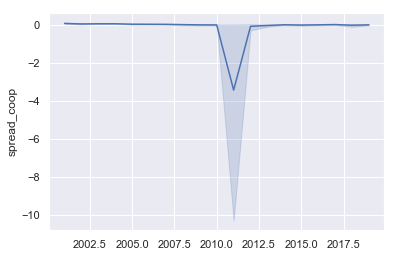

In [26]:
sns.lineplot(completo_coop.drop_duplicates().index, completo_coop.drop_duplicates().spread_coop)